# Get Dataset from Kaggel

Install kaggle to download dataset

In [2]:
! pip -q install kaggle

In [124]:
import kaggle
import os
import shutil
import json

In [ ]:


# Authenticate with your Kaggle account
kaggle.api.authenticate()

# Details of Dataset
dataset_id = "ayuraj/asl-dataset"
Path = "American_Sign_Language_Dataset"
metadata = 'dataset-metadata.json'

# Check if metadata file exists
if not os.path.exists(os.path.join(Path,metadata)):
    kaggle.api.dataset_metadata(dataset_id , path=Path)

# Open the dataset-metadata.JSON file
with open(os.path.join(Path,metadata)) as file:
    dataset_metadata = json.load(file)

dataset_name = (dataset_metadata["datasetSlug"])

# Check if dataset exists
if not os.path.exists(os.path.join(Path,dataset_name+'.zip')):
    # Download a dataset
    kaggle.api.dataset_download_files(dataset, path=Path , quiet=False)



In [7]:
# Extract the downloaded files if necessary
import zipfile
with zipfile.ZipFile(os.path.join(Path, dataset_name + '.zip'), 'r') as zip_ref:
    zip_ref.extractall(Path)

# Traing Sign Language Deep Learning Model

## 1. Import and Install Dependencies

In [ ]:
! pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

2023-10-15 17:19:16.337442: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 17:19:16.546377: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-15 17:19:16.547579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 17:19:17.862594: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

> in nwe version of holistic `FACE_CONNECTIONS` seems to be renamed/replaced by `FACEMESH_TESSELATION`

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # while cap.isOpened():
    while True:

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/omarf/Project/Sign_Language_Charecter_Detection/Sign_Detect_0.1/lib/python3.11/site-packages/cv2/qt/plugins"


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [7]:
draw_landmarks(frame, results)

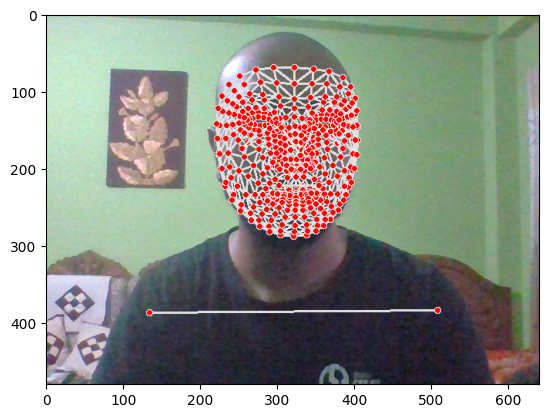

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

## 3. Extract Keypoint Values

In [9]:
len(results.left_hand_landmarks.landmark)
# len(results)

AttributeError: 'NoneType' object has no attribute 'landmark'

In [10]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [11]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [12]:
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
result_test = extract_keypoints(results)
result_test

array([ 0.51669818,  0.38268471, -1.43595481, ...,  0.        ,
        0.        ,  0.        ])

In [15]:
np.save('0', result_test)
np.load('0.npy')

array([ 0.51669818,  0.38268471, -1.43595481, ...,  0.        ,
        0.        ,  0.        ])

## 4. Setup Folders for Collection

In [16]:
doc = "Docs"
text_file = "actions.txt"
with open(os.path.join(doc, text_file), 'r') as f:
    action_str = f.read() 

# list to np array
action_names = np.array(action_str.split('.'))
actions = np.arange(len(action_names))
print(action_names)
print(actions)

['Hello' ' I love you ' ' Thank you' '']
[0 1 2 3]


In [17]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
# actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [22]:
# Remove the directory if it exists
import shutil
if os.path.exists(DATA_PATH):
    shutil.rmtree(DATA_PATH)

In [23]:
# Create the directory
os.makedirs(DATA_PATH , exist_ok=True)

for action in actions:
    os.makedirs(os.path.join(DATA_PATH , str(action)) , exist_ok=True)


for action in actions: 
    # dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, str(action), str(sequence)))
        except:
            pass

## 5. Collect Keypoint Values for Training and Testing

In [24]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(1, no_sequences+1):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action_names[action], sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action_names[action], sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, str(action), str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [25]:
cap.release()
cv2.destroyAllWindows()

## 6. Preprocess Data and Create Labels and Features

In [26]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [27]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{0: 0, 1: 1, 2: 2, 3: 3}

In [28]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, str(action)))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, str(action), str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [29]:
np.array(sequences).shape

(120, 30, 1662)

In [30]:
np.array(labels).shape

(120,)

In [31]:
X = np.array(sequences)
X.shape

(120, 30, 1662)

In [32]:
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
y_test.shape

(6, 4)

## 7. Build and Train LSTM Neural Network

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [34]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [35]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [36]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=600, callbacks=[tb_callback])
model.summary()

Epoch 1/600
4/4 [==============================] - 5s 62ms/step - loss: 1.4309 - categorical_accuracy: 0.2368
Epoch 2/600
4/4 [==============================] - 0s 59ms/step - loss: 1.2706 - categorical_accuracy: 0.2281
Epoch 3/600
4/4 [==============================] - 0s 64ms/step - loss: 1.2052 - categorical_accuracy: 0.3421
Epoch 4/600
4/4 [==============================] - 0s 58ms/step - loss: 1.0559 - categorical_accuracy: 0.4211
Epoch 5/600
4/4 [==============================] - 0s 57ms/step - loss: 1.1044 - categorical_accuracy: 0.6140
Epoch 6/600
4/4 [==============================] - 0s 60ms/step - loss: 1.6179 - categorical_accuracy: 0.5175
Epoch 7/600
4/4 [==============================] - 0s 61ms/step - loss: 1.3034 - categorical_accuracy: 0.5088
Epoch 8/600
4/4 [==============================] - 0s 58ms/step - loss: 1.2005 - categorical_accuracy: 0.5439
Epoch 9/600
4/4 [==============================] - 0s 61ms/step - loss: 0.9506 - categorical_accuracy: 0.7456
Epoch 10/6

In [37]:
sign_action = np.load('MP_Data/0/1/0.npy')


## 8. Make Predictions

In [38]:
res = model.predict(X_test)
actions[np.argmax(res[4])]

1/1 [==============================] - 1s 506ms/step


0

In [39]:
actions[np.argmax(y_test[4])]

0

## 9. Save Weights

In [40]:
model.save('action.h5')


/home/omarf/Project/Sign_Language_Charecter_Detection/Sign_Detect_0.1/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
del model


In [88]:
model.load_weights('action.h5')

## 10. Evaluation using Confusion Matrix and Accuracy

In [41]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [42]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

1/1 [==============================] - 0s 28ms/step


array([[[4, 0],
        [1, 1]],

       [[4, 0],
        [0, 2]],

       [[4, 1],
        [0, 1]],

       [[5, 0],
        [0, 1]]])

In [43]:
accuracy_score(ytrue, yhat)

0.8333333333333334

## 11. Test in Real Time

In [44]:
from scipy import stats

In [45]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [47]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [56]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

        #     # Viz probabilities
        #     image = prob_viz(res, action_names, image, colors)
            
        # cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        # cv2.putText(image, ' '.join(sentence), (3,30), 
        #                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        
        
        # # Show to screen
        # cv2.imshow('OpenCV Feed', image)
        
        # output = str(actions[np.argmax(res)])
        output = action_names[np.argmax(res)]
        # Add text into cv
        img = cv2.putText(image, output, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('OpenCV Feed', img)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti